In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available and being used.")
    print("List of GPUs:", gpus)
else:
    print("GPU is not available. TensorFlow is running on CPU.")

2025-05-12 14:25:16.612212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747059916.830707      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747059916.895237      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is available and being used.
List of GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns

train_path = "/kaggle/input/scene-classification/Scene Classification/train"
test_path = "/kaggle/input/scene-classification/Scene Classification/test"

if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError("Train or Test folders not found. Check the path!")

3.1 Part A: Implementing Convolutional Neural Network from scratch

3.1.1 Data Understanding, Analysis, Visualization and Cleaning

In [ ]:
def count_images(folder_path):
    total = 0
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            total += len(os.listdir(class_path))
    return total

print(f"Total training images: {count_images(train_path)}")
print(f"Total test images: {count_images(test_path)}")

classes = os.listdir(train_path)
print("\nClasses in the dataset:", classes)

Total training images: 14034
Total test images: 3000

Classes in the dataset: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


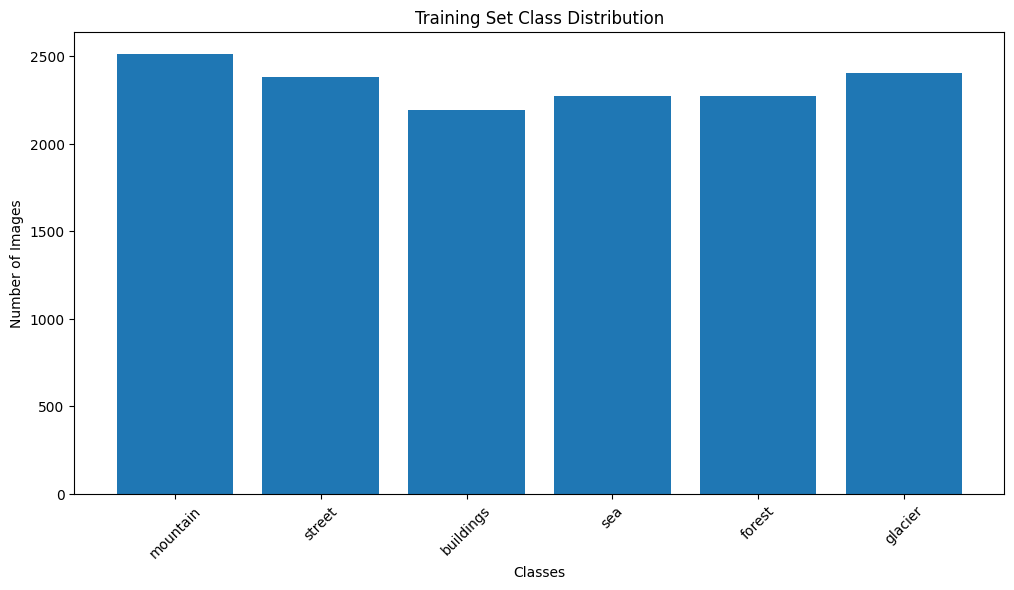

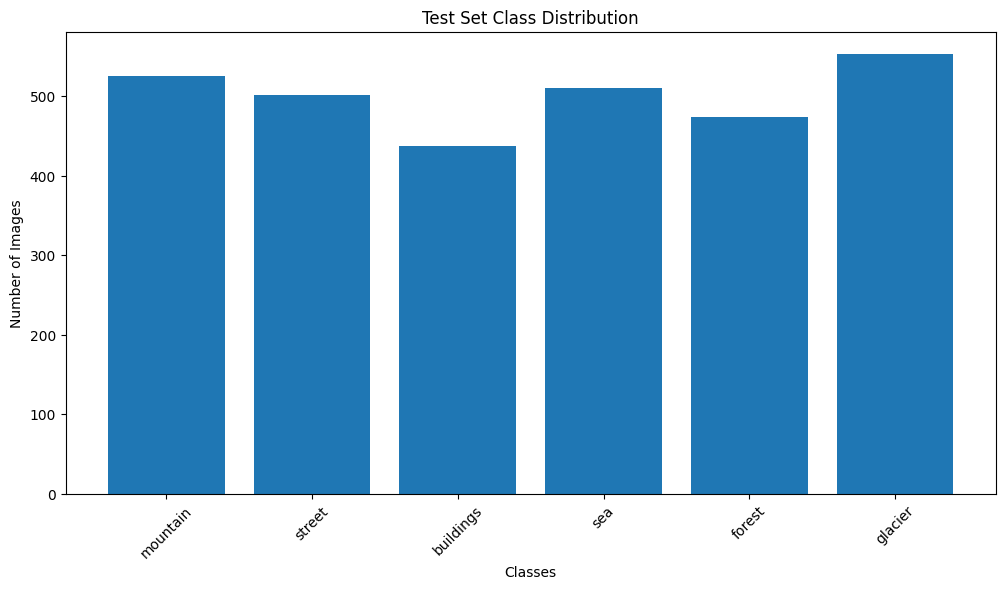

In [ ]:
def plot_class_distribution(folder_path, title):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    return class_counts

train_counts = plot_class_distribution(train_path, "Training Set Class Distribution")
test_counts = plot_class_distribution(test_path, "Test Set Class Distribution")

In [ ]:
def analyze_image_dimensions(folder_path):
    dimensions = []
    corrupted_images = []

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        dimensions.append(img.size)
                except:
                    corrupted_images.append(img_path)

    if dimensions:
        widths, heights = zip(*dimensions)
        print(f"Average width: {np.mean(widths):.2f}, Average height: {np.mean(heights):.2f}")
        print(f"Min width: {min(widths)}, Min height: {min(heights)}")
        print(f"Max width: {max(widths)}, Max height: {max(heights)}")

    if corrupted_images:
        print(f"\nFound {len(corrupted_images)} corrupted images:")
        for img in corrupted_images[:5]:
            print(img)

    return corrupted_images

print("\nTraining set image dimensions:")
train_corrupted = analyze_image_dimensions(train_path)

print("\nTest set image dimensions:")
test_corrupted = analyze_image_dimensions(test_path)


Training set image dimensions:
Average width: 150.00, Average height: 149.91
Min width: 150, Min height: 76
Max width: 150, Max height: 150

Found 42 corrupted images:
/kaggle/input/scene-classification/Scene Classification/train/mountain/17234.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/8725.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/14560.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/16180.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/15719.jpg

Test set image dimensions:
Average width: 150.00, Average height: 149.90
Min width: 150, Min height: 72
Max width: 150, Max height: 150


In [ ]:
import os
import shutil
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

train_path = "/kaggle/input/scene-classification/Scene Classification/train"
test_path = "/kaggle/input/scene-classification/Scene Classification/test"

train_clean_path = "/kaggle/working/train_clean"
test_clean_path = "/kaggle/working/test_clean"

def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except (UnidentifiedImageError, IOError, OSError):
        return False

def copy_valid_images(src_path, dst_path):
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)

    for root, _, files in os.walk(src_path):
        for file in tqdm(files, desc=f"Checking in {root}"):
            src_file_path = os.path.join(root, file)

            # Recreate the same folder structure in dst
            rel_path = os.path.relpath(root, src_path)
            dst_dir = os.path.join(dst_path, rel_path)
            if not os.path.exists(dst_dir):
                os.makedirs(dst_dir)

            dst_file_path = os.path.join(dst_dir, file)

            if is_valid_image(src_file_path):
                shutil.copy2(src_file_path, dst_file_path)

print("Copying valid train images...")
copy_valid_images(train_path, train_clean_path)

print("Copying valid test images...")
copy_valid_images(test_path, test_clean_path)


Copying valid train images...


Checking in /kaggle/input/scene-classification/Scene Classification/train: 0it [00:00, ?it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/train/mountain: 100%|██████████| 2512/2512 [00:03<00:00, 698.73it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/train/street: 100%|██████████| 2382/2382 [00:03<00:00, 691.16it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/train/buildings: 100%|██████████| 2191/2191 [00:03<00:00, 716.68it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/train/sea: 100%|██████████| 2274/2274 [00:03<00:00, 606.64it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/train/forest: 100%|██████████| 2271/2271 [00:03<00:00, 692.20it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/train/glacier: 100%|██████████| 2404/2404 [00:03<00:00, 730.22it/s]


Copying valid test images...


Checking in /kaggle/input/scene-classification/Scene Classification/test: 0it [00:00, ?it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/test/mountain: 100%|██████████| 525/525 [00:00<00:00, 758.86it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/test/street: 100%|██████████| 501/501 [00:00<00:00, 756.29it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/test/buildings: 100%|██████████| 437/437 [00:00<00:00, 710.91it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/test/sea: 100%|██████████| 510/510 [00:00<00:00, 744.21it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/test/forest: 100%|██████████| 474/474 [00:00<00:00, 670.17it/s]
Checking in /kaggle/input/scene-classification/Scene Classification/test/glacier: 100%|██████████| 553/553 [00:00<00:00, 689.80it/s]


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


=== DATASET OVERVIEW AFTER CLEANING ===

Total training images after cleaning: 14034
Total test images after cleaning: 3000
Total images in dataset: 17034

Removed 42 corrupted images from training set (0.30%)
Removed 0 corrupted images from test set (0.00%)

=== UPDATED CLASS DISTRIBUTION ===

Training set:


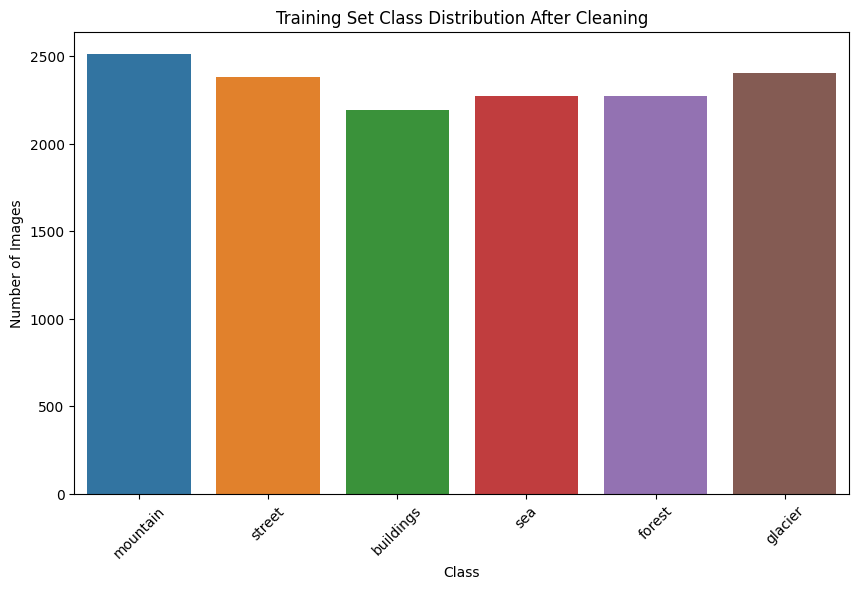


Test set:


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


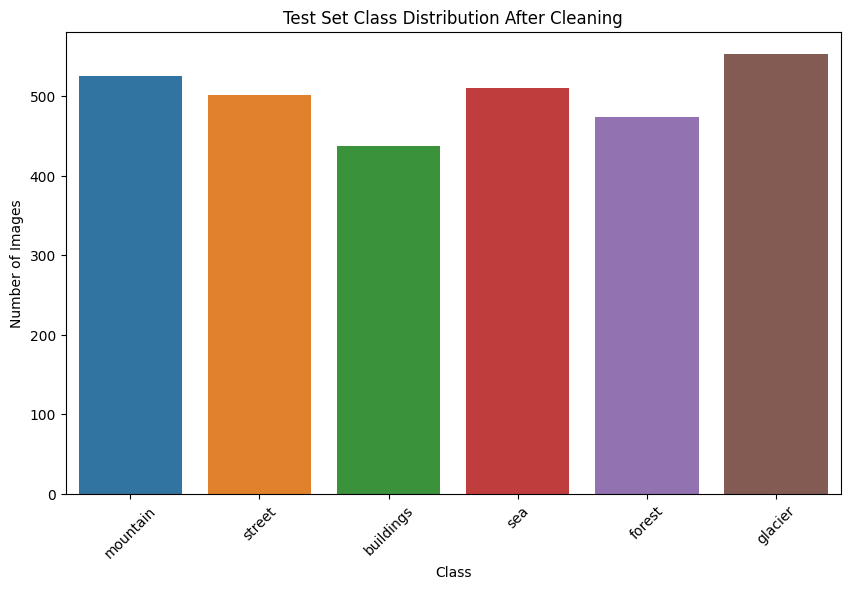


Class-wise image counts in training set:
mountain: 2512
street: 2382
buildings: 2191
sea: 2274
forest: 2271
glacier: 2404

Class-wise image counts in test set:
mountain: 525
street: 501
buildings: 437
sea: 510
forest: 474
glacier: 553

=== IMAGE DIMENSIONS AFTER CLEANING ===

Training set image dimensions:
Average width: 150.00, Average height: 149.91
Min width: 150, Min height: 76
Max width: 150, Max height: 150

Found 42 corrupted images:
/kaggle/input/scene-classification/Scene Classification/train/mountain/17234.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/8725.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/14560.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/16180.jpg
/kaggle/input/scene-classification/Scene Classification/train/mountain/15719.jpg

Test set image dimensions:
Average width: 150.00, Average height: 149.90
Min width: 150, Min height: 72
Max width: 150, Max height: 150


In [ ]:
def plot_class_distribution(folder_path, title):
    class_counts = {}

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    return class_counts

def updated_dataset_analysis():
    def count_cleaned_images(folder_path):
        total = 0
        for class_name in os.listdir(folder_path):
            class_path = os.path.join(folder_path, class_name)
            if os.path.isdir(class_path):
                total += len(os.listdir(class_path))
        return total
    cleaned_train_count = count_cleaned_images(train_path)
    cleaned_test_count = count_cleaned_images(test_path)

    print("=== DATASET OVERVIEW AFTER CLEANING ===")
    print(f"\nTotal training images after cleaning: {cleaned_train_count}")
    print(f"Total test images after cleaning: {cleaned_test_count}")
    print(f"Total images in dataset: {cleaned_train_count + cleaned_test_count}")

    original_train = cleaned_train_count + len(train_corrupted)
    original_test = cleaned_test_count + len(test_corrupted)

    print(f"\nRemoved {len(train_corrupted)} corrupted images from training set "
          f"({len(train_corrupted)/original_train*100:.2f}%)")
    print(f"Removed {len(test_corrupted)} corrupted images from test set "
          f"({len(test_corrupted)/original_test*100:.2f}%)")

    print("\n=== UPDATED CLASS DISTRIBUTION ===")
    print("\nTraining set:")
    cleaned_train_counts = plot_class_distribution(train_path, "Training Set Class Distribution After Cleaning")

    print("\nTest set:")
    cleaned_test_counts = plot_class_distribution(test_path, "Test Set Class Distribution After Cleaning")

    print("\nClass-wise image counts in training set:")
    for class_name, count in cleaned_train_counts.items():
        print(f"{class_name}: {count}")

    print("\nClass-wise image counts in test set:")
    for class_name, count in cleaned_test_counts.items():
        print(f"{class_name}: {count}")

    print("\n=== IMAGE DIMENSIONS AFTER CLEANING ===")
    print("\nTraining set image dimensions:")
    analyze_image_dimensions(train_path)

    print("\nTest set image dimensions:")
    analyze_image_dimensions(test_path)

updated_dataset_analysis()

Found 13992 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

Training Set After Balancing:
Total batches: 438
Classes: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Samples per class: 2332


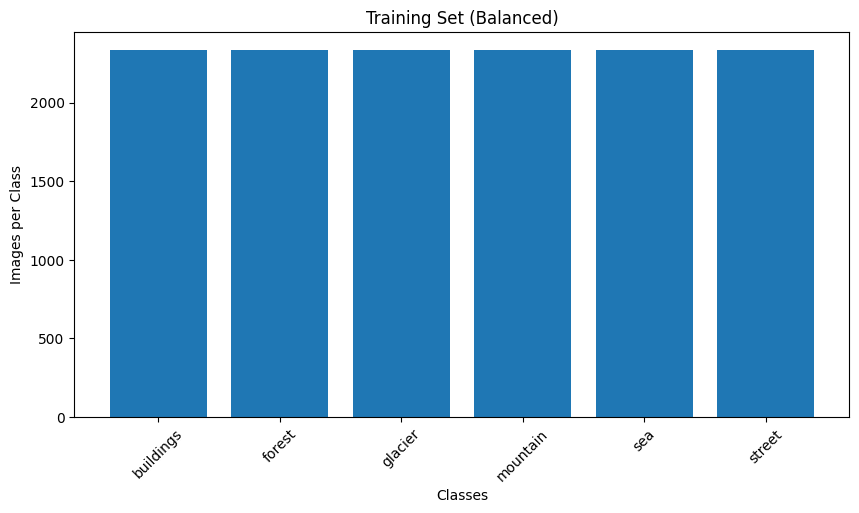

In [ ]:
train_clean_path = "/kaggle/working/train_clean"
test_clean_path = "/kaggle/working/test_clean"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_clean_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_clean_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("\nTraining Set After Balancing:")
print(f"Total batches: {len(train_generator)}")
print(f"Classes: {train_generator.class_indices}")
print(f"Samples per class: {train_generator.samples // len(train_generator.class_indices)}")

def plot_balanced_distribution(generator, title):
    samples = generator.samples
    num_classes = len(generator.class_indices)
    per_class = samples // num_classes

    plt.figure(figsize=(10,5))
    plt.bar(generator.class_indices.keys(), [per_class]*num_classes)
    plt.title(f'{title} (Balanced)')
    plt.xlabel('Classes')
    plt.ylabel('Images per Class')
    plt.xticks(rotation=45)
    plt.show()

plot_balanced_distribution(train_generator, "Training Set")


Training set samples:


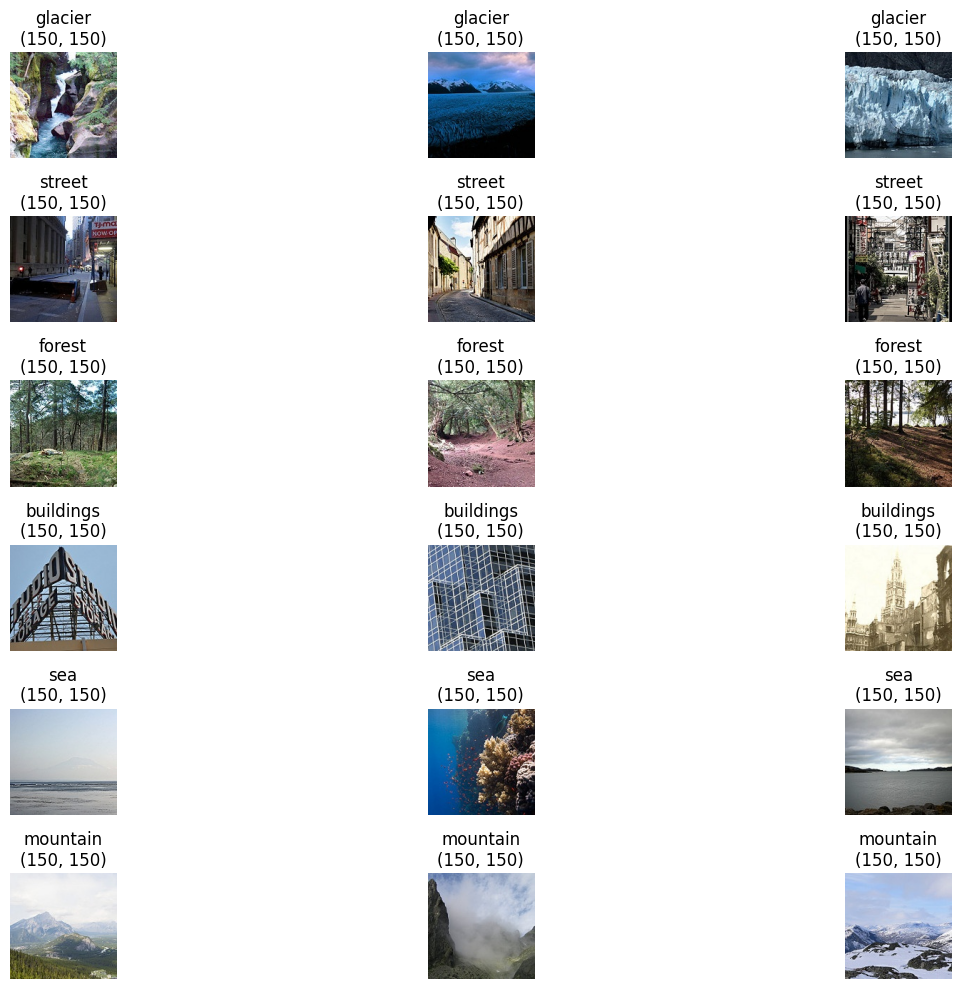


Test set samples:


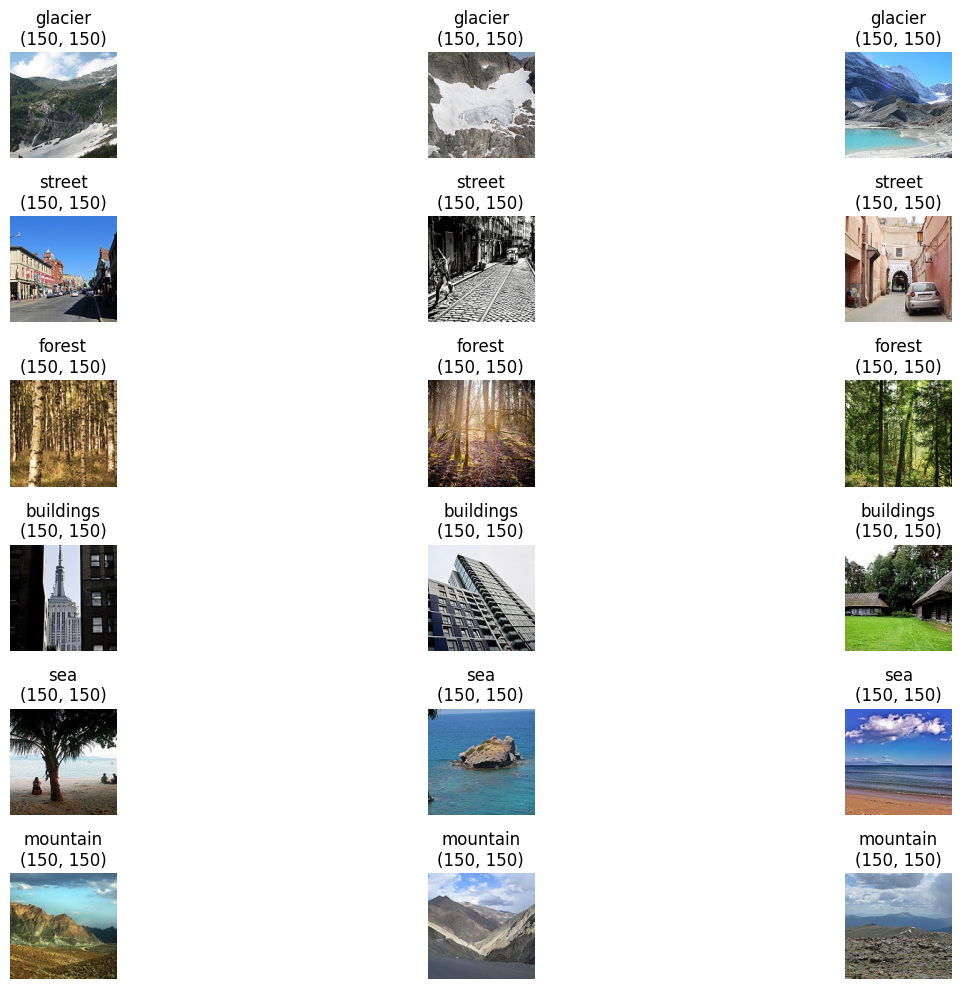

In [ ]:
def visualize_samples(folder_path, samples_per_class=3):
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)[:samples_per_class]

            for j, img_name in enumerate(images):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = Image.open(img_path)

                    plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
                    plt.imshow(img)
                    plt.title(f"{class_name}\n{img.size}")
                    plt.axis('off')

                except:
                    print(f"Could not display image: {img_path}")

    plt.tight_layout()
    plt.show()

print("Training set samples:")
visualize_samples(train_clean_path)

print("\nTest set samples:")
visualize_samples(test_clean_path)


Found 11196 images belonging to 6 classes.
Found 2796 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


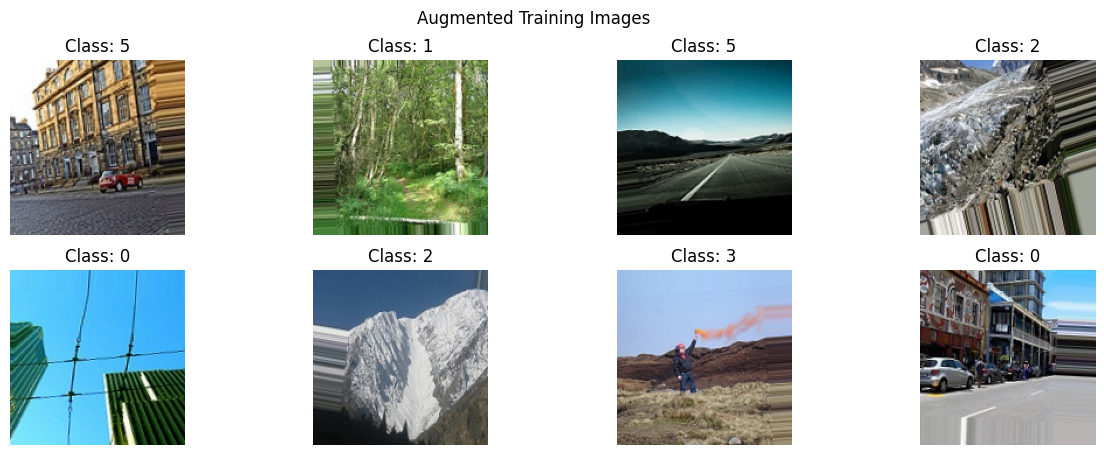

Class indices from generator: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [ ]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_clean_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_clean_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_clean_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

def visualize_augmented_images(generator, num_images=8):
    x_batch, y_batch = next(generator)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, 4, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"Class: {np.argmax(y_batch[i])}")
        plt.axis('off')
    plt.suptitle('Augmented Training Images')
    plt.show()

visualize_augmented_images(train_generator)
print("Class indices from generator:", train_generator.class_indices)

**3.1.2 Design, Train, and Evaluate a Baseline Model :**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def create_baseline_model(input_shape=(150, 150, 3), num_classes=6):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

baseline_model = create_baseline_model()
baseline_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │      21,234,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,181,126 (84.61 MB)

 Trainable params: 22,181,126 (84.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 85s 221ms/step - accuracy: 0.3332 - loss: 1.5749 - val_accuracy: 0.5730 - val_loss: 1.0684
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.5444 - loss: 1.1391 - val_accuracy: 0.6388 - val_loss: 0.9456
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 207ms/step - accuracy: 0.6174 - loss: 1.0055 - val_accuracy: 0.6674 - val_loss: 0.8679
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.6675 - loss: 0.9002 - val_accuracy: 0.6828 - val_loss: 0.8106
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 73s 205ms/step - accuracy: 0.6781 - loss: 0.9034 - val_accuracy: 0.7282 - val_loss: 0.7586
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.7075 - loss: 0.8452 - val_accuracy: 0.7457 - val_loss: 0.7154
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 72s 204ms/step - accuracy: 0.7358 - loss: 0.7588 - val_accuracy: 0.7532 - val_loss: 0.6700
Epoch 8/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.7557 - loss: 0

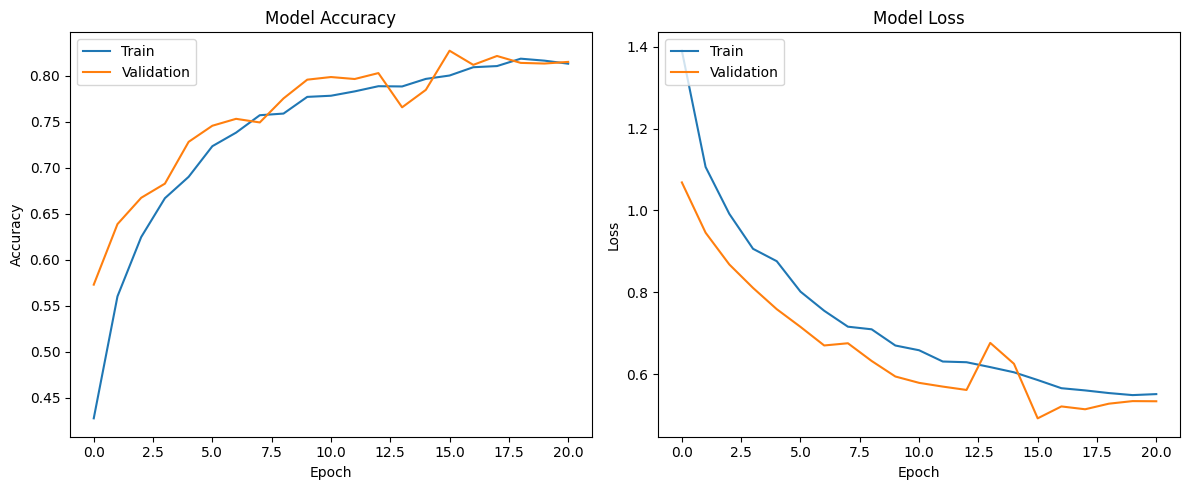

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = baseline_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8690 - loss: 0.3903

Test Accuracy: 0.8510
Test Loss: 0.4377
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step

Classification Report:
              precision    recall  f1-score   support

   buildings       0.84      0.86      0.85       437
      forest       0.93      0.99      0.96       474
     glacier       0.79      0.81      0.80       553
    mountain       0.82      0.76      0.79       525
         sea       0.84      0.83      0.84       510
      street       0.88      0.87      0.87       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



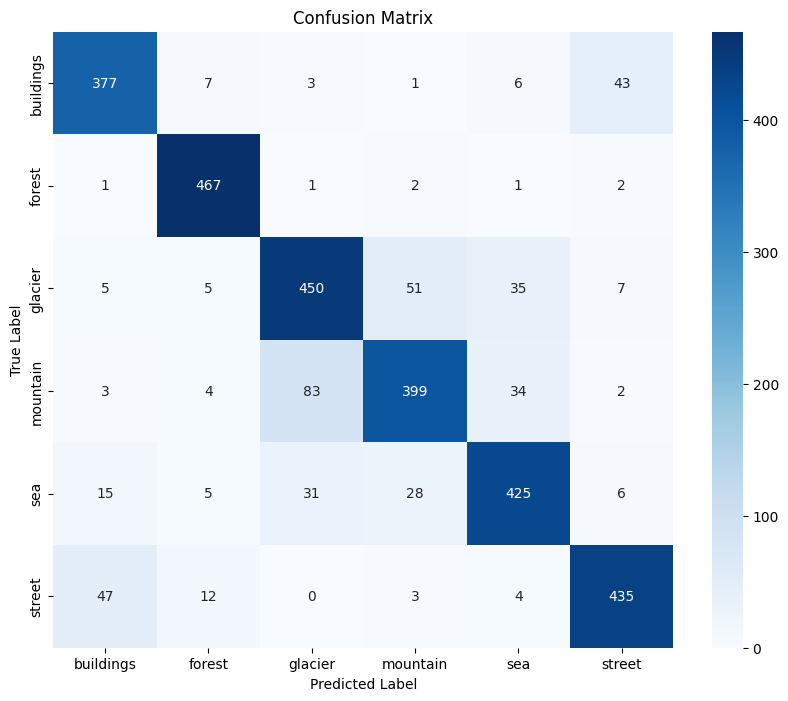

Found 3000 images belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


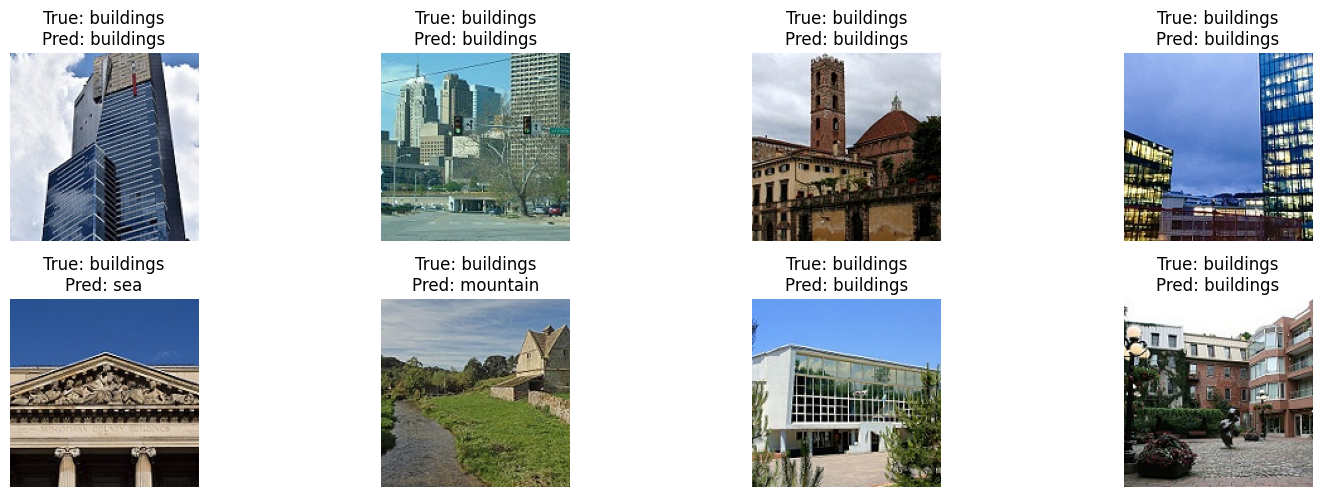

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loss, test_acc = baseline_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = baseline_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_true, y_pred_classes, class_names)

def visualize_predictions(model, generator, num_samples=8):
    x_batch, y_batch = next(generator)
    y_true = np.argmax(y_batch, axis=1)
    y_pred = np.argmax(model.predict(x_batch), axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"True: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

sample_generator = test_datagen.flow_from_directory(
    test_clean_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


visualize_predictions(baseline_model, sample_generator)

**3.1.3 Design, Train , and Evaluate Deeper Architecture with Regularization Layer**

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

def create_deeper_model(input_shape=(150, 150, 3), num_classes=6):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001),
               input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(512, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same',
               kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu',
              kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu',
              kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(0.001)),

        Dense(num_classes, activation='softmax')
    ])

    return model

deeper_model = create_deeper_model()
deeper_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

print("Deeper Model Architecture:")
deeper_model.summary()

print("\nComparison with Baseline Model:")
print(f"Baseline model parameters: {baseline_model.count_params():,}")
print(f"Deeper model parameters: {deeper_model.count_params():,}")

Deeper Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,095,302 (99.55 MB)

 Trainable params: 26,089,926 (99.53 MB)

 Non-trainable params: 5,376 (21.00 KB)


Comparison with Baseline Model:
Baseline model parameters: 22,181,126
Deeper model parameters: 26,095,302



Training deeper model...
Epoch 1/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 182s 401ms/step - accuracy: 0.4513 - loss: 4.5752 - val_accuracy: 0.1620 - val_loss: 7.0384 - learning_rate: 1.0000e-04
Epoch 2/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 271ms/step - accuracy: 0.6124 - loss: 4.0770 - val_accuracy: 0.4768 - val_loss: 4.7055 - learning_rate: 1.0000e-04
Epoch 3/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 270ms/step - accuracy: 0.6640 - loss: 3.8626 - val_accuracy: 0.5079 - val_loss: 4.7131 - learning_rate: 1.0000e-04
Epoch 4/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 271ms/step - accuracy: 0.6840 - loss: 3.7091 - val_accuracy: 0.5601 - val_loss: 4.1636 - learning_rate: 1.0000e-04
Epoch 5/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 270ms/step - accuracy: 0.7033 - loss: 3.5668 - val_accuracy: 0.6069 - val_loss: 3.8259 - learning_rate: 1.0000e-04
Epoch 6/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 271ms/step - accuracy: 0.7307 - loss: 3.3916 - val_accuracy: 0.6220 - val_loss: 3.7150 - learning_rate: 1.0000e-04
Epoch 7/35
350/350 

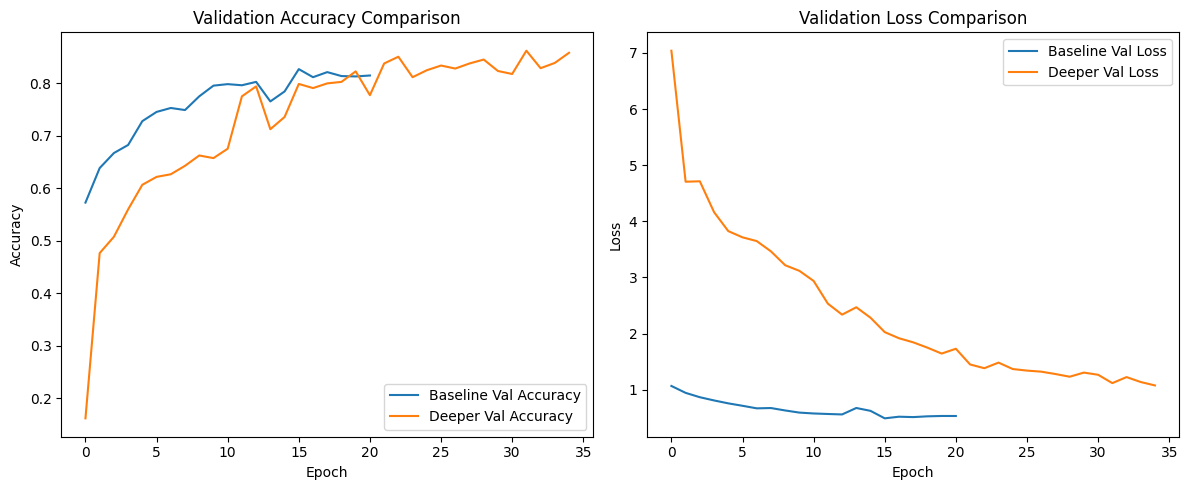


Training Time Comparison:
Baseline model: 21 epochs
Deeper model: 35 epochs
Deeper model took 97.64 seconds per epoch


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)
]

import time

print("\nTraining deeper model...")
start_time = time.time()

deeper_history = deeper_model.fit(
    train_generator,
    epochs=35,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Baseline Val Accuracy')
plt.plot(deeper_history.history['val_accuracy'], label='Deeper Val Accuracy')
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Baseline Val Loss')
plt.plot(deeper_history.history['val_loss'], label='Deeper Val Loss')
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

print("\nTraining Time Comparison:")
print(f"Baseline model: {len(history.epoch)} epochs")
print(f"Deeper model: {len(deeper_history.epoch)} epochs")
print(f"Deeper model took {training_time/len(deeper_history.epoch):.2f} seconds per epoch")


Evaluating deeper model on test set...
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.9069 - loss: 0.9536

Test Accuracy: 0.8080 (Baseline: 0.8510)
Test Loss: 1.2273 (Baseline: 0.4377)
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step

Classification Report (Deeper Model):
              precision    recall  f1-score   support

   buildings       0.60      0.96      0.74       437
      forest       0.85      0.97      0.91       474
     glacier       0.84      0.84      0.84       553
    mountain       0.89      0.73      0.80       525
         sea       0.87      0.89      0.88       510
      street       0.95      0.48      0.64       501

    accuracy                           0.81      3000
   macro avg       0.83      0.81      0.80      3000
weighted avg       0.84      0.81      0.80      3000



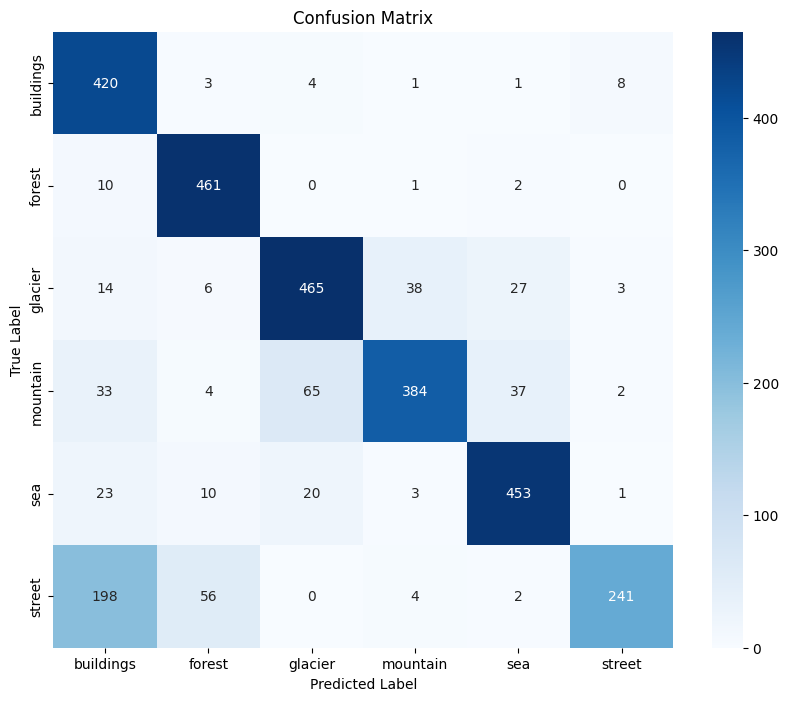

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step


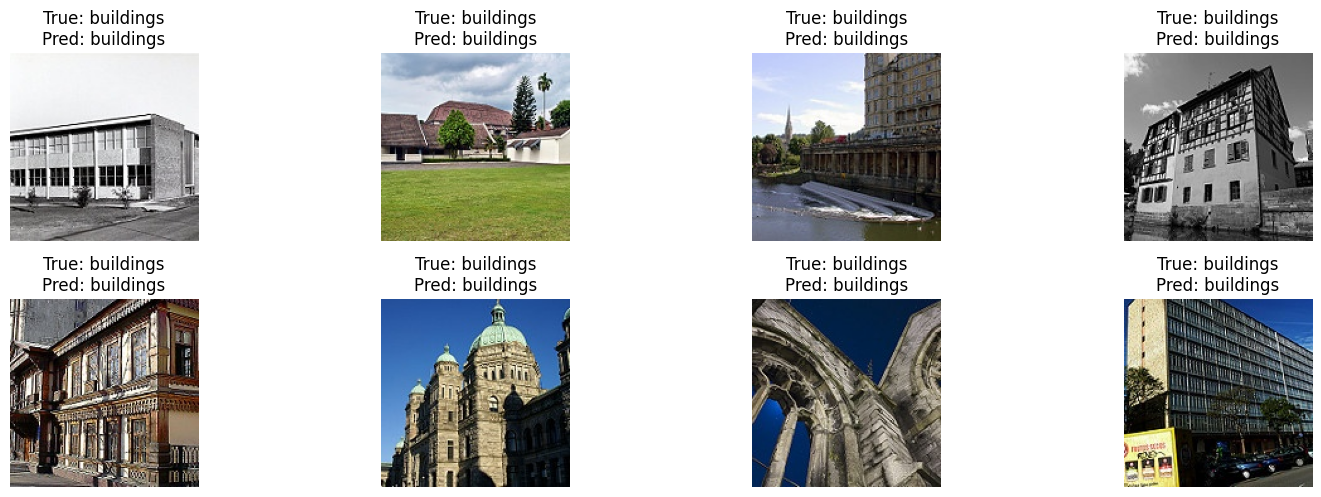

In [ ]:
print("\nEvaluating deeper model on test set...")
deeper_test_loss, deeper_test_acc = deeper_model.evaluate(test_generator)
print(f"\nTest Accuracy: {deeper_test_acc:.4f} (Baseline: {test_acc:.4f})")
print(f"Test Loss: {deeper_test_loss:.4f} (Baseline: {test_loss:.4f})")

deeper_y_pred = deeper_model.predict(test_generator)
deeper_y_pred_classes = np.argmax(deeper_y_pred, axis=1)

print("\nClassification Report (Deeper Model):")
print(classification_report(y_true, deeper_y_pred_classes, target_names=class_names))


plot_confusion_matrix(y_true, deeper_y_pred_classes, class_names)

visualize_predictions(deeper_model, sample_generator)

**3.1.4 Experimentation and Comparative Analysis**

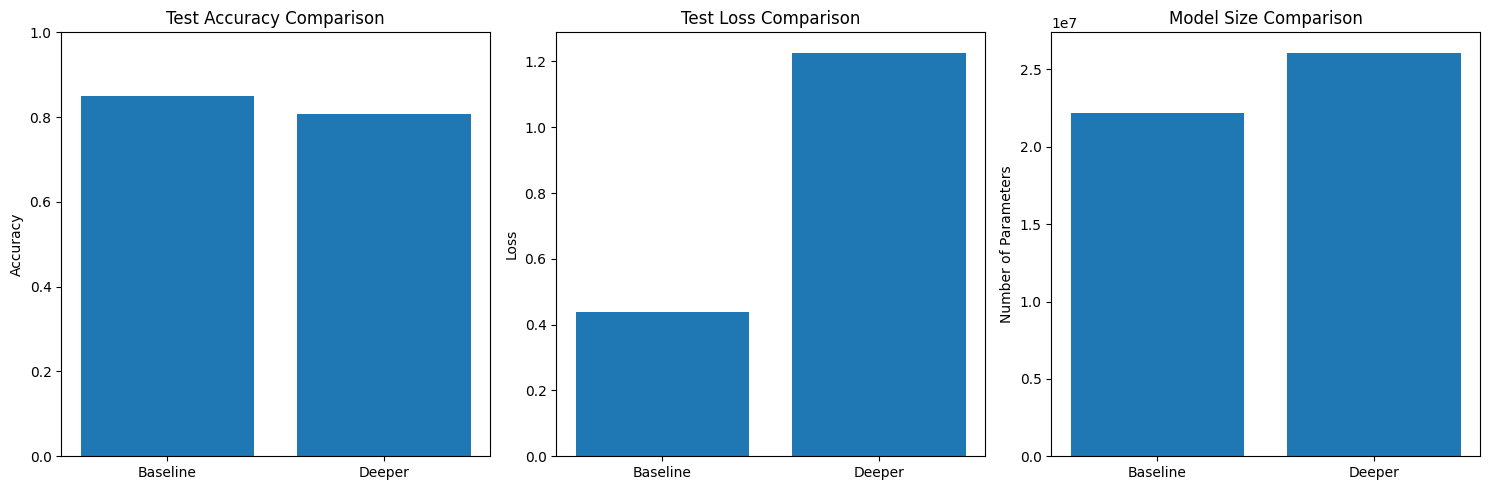


=== METRICS COMPARISON ===
Metric              Baseline       Deeper         Difference     
Accuracy            0.8510     0.8080     -0.0430
Loss                0.4377     1.2273     +0.7896
Parameters          22,181,126     26,095,302     +3,914,176

Class-wise F1-score Comparison:
Class          Baseline       Deeper         Improvement    
buildings      0.8520     0.7401     -0.1119
forest         0.9589     0.9093     -0.0497
glacier        0.8029     0.8401     +0.0373
mountain       0.7909     0.8033     +0.0125
sea            0.8374     0.8779     +0.0405
street         0.8735     0.6376     -0.2359


In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(['Baseline', 'Deeper'], [test_acc, deeper_test_acc])
plt.title('Test Accuracy Comparison')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.bar(['Baseline', 'Deeper'], [test_loss, deeper_test_loss])
plt.title('Test Loss Comparison')
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
plt.bar(['Baseline', 'Deeper'],
        [baseline_model.count_params(), deeper_model.count_params()])
plt.title('Model Size Comparison')
plt.ylabel('Number of Parameters')
plt.tight_layout()
plt.show()

print("\n=== METRICS COMPARISON ===")
print(f"{'Metric':<20}{'Baseline':<15}{'Deeper':<15}{'Difference':<15}")
print(f"{'Accuracy':<20}{test_acc:.4f}{'':<5}{deeper_test_acc:.4f}{'':<5}{deeper_test_acc-test_acc:+.4f}")
print(f"{'Loss':<20}{test_loss:.4f}{'':<5}{deeper_test_loss:.4f}{'':<5}{deeper_test_loss-test_loss:+.4f}")
print(f"{'Parameters':<20}{baseline_model.count_params():,}{'':<5}{deeper_model.count_params():,}{'':<5}"
      f"{deeper_model.count_params()-baseline_model.count_params():+,}")

def compare_class_metrics(y_true, pred1, pred2, class_names):
    report1 = classification_report(y_true, pred1, target_names=class_names, output_dict=True)
    report2 = classification_report(y_true, pred2, target_names=class_names, output_dict=True)

    print("\nClass-wise F1-score Comparison:")
    print(f"{'Class':<15}{'Baseline':<15}{'Deeper':<15}{'Improvement':<15}")
    for cls in class_names:
        f1_1 = report1[cls]['f1-score']
        f1_2 = report2[cls]['f1-score']
        print(f"{cls:<15}{f1_1:.4f}{'':<5}{f1_2:.4f}{'':<5}{f1_2-f1_1:+.4f}")

compare_class_metrics(y_true, y_pred_classes, deeper_y_pred_classes, class_names)

No 'time' metric in history - using 0


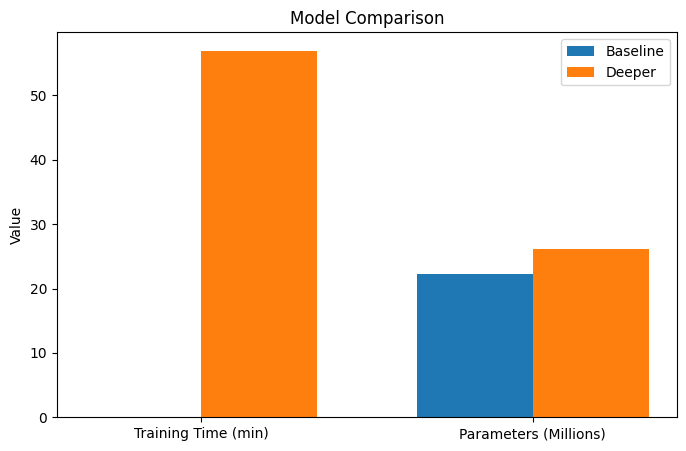


=== MODEL COMPARISON ===
Metric                    |   Baseline |     Deeper | Difference
-------------------------------------------------------
Training Time (min)       |       0.00 |      56.96 |      56.96
Parameters (Millions)     |      22.18 |      26.10 |       3.91


In [ ]:
try:
    baseline_time = len(history.epoch) * np.mean(history.history['time']) / 60
except KeyError:
    print("No 'time' metric in history - using 0")
    baseline_time = 0

try:
    deeper_time = training_time / 60
except NameError:
    print("No training_time variable - using 0")
    deeper_time = 0

metrics = ['Training Time (min)', 'Parameters (Millions)']
baseline_vals = [
    baseline_time,
    baseline_model.count_params() / 1e6
]
deeper_vals = [
    deeper_time,
    deeper_model.count_params() / 1e6
]

# Create plot
plt.figure(figsize=(8, 5))
x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, baseline_vals, width, label='Baseline')
plt.bar(x + width/2, deeper_vals, width, label='Deeper')

plt.ylabel('Value')
plt.title('Model Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.show()

print("\n=== MODEL COMPARISON ===")
print(f"{'Metric':<25} | {'Baseline':>10} | {'Deeper':>10} | {'Difference':>10}")
print("-" * 55)
print(f"{'Training Time (min)':<25} | {baseline_vals[0]:>10.2f} | {deeper_vals[0]:>10.2f} | {deeper_vals[0]-baseline_vals[0]:>10.2f}")
print(f"{'Parameters (Millions)':<25} | {baseline_vals[1]:>10.2f} | {deeper_vals[1]:>10.2f} | {deeper_vals[1]-baseline_vals[1]:>10.2f}")


Training deeper model with SGD...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 118s 294ms/step - accuracy: 0.4113 - loss: 4.6608 - val_accuracy: 0.2622 - val_loss: 4.9161 - learning_rate: 0.0010
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 94s 264ms/step - accuracy: 0.5807 - loss: 4.1564 - val_accuracy: 0.5719 - val_loss: 4.1429 - learning_rate: 0.0010
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 93s 263ms/step - accuracy: 0.6266 - loss: 3.9980 - val_accuracy: 0.5622 - val_loss: 4.2199 - learning_rate: 0.0010
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 94s 264ms/step - accuracy: 0.6609 - loss: 3.9084 - val_accuracy: 0.5190 - val_loss: 4.5102 - learning_rate: 0.0010
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 93s 263ms/step - accuracy: 0.7026 - loss: 3.7527 - val_accuracy: 0.5451 - val_loss: 4.3763 - learning_rate: 0.0010
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 93s 263ms/step - accuracy: 0.7087 - loss: 3.7063 - val_accuracy: 0.5447 - val_loss: 4.2647 - learning_rate: 0.0010
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 93s 263ms/step - accuracy: 0.

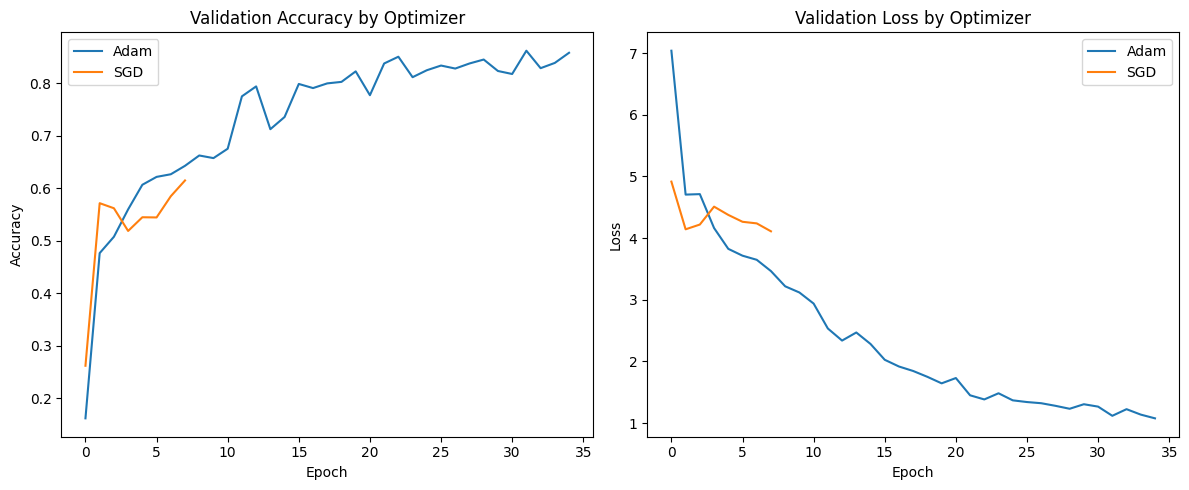


=== OPTIMIZER COMPARISON ===
Metric         SGD            Adam           Difference     
Accuracy       0.3130     0.8080     +0.4950
Loss           4.7415     1.2273     -3.5142
Epochs         8     35     +27


In [ ]:
deeper_model_sgd = create_deeper_model()
deeper_model_sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

print("\nTraining deeper model with SGD...")
sgd_history = deeper_model_sgd.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

sgd_test_loss, sgd_test_acc = deeper_model_sgd.evaluate(test_generator)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(deeper_history.history['val_accuracy'], label='Adam')
plt.plot(sgd_history.history['val_accuracy'], label='SGD')
plt.title('Validation Accuracy by Optimizer')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(deeper_history.history['val_loss'], label='Adam')
plt.plot(sgd_history.history['val_loss'], label='SGD')
plt.title('Validation Loss by Optimizer')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

print("\n=== OPTIMIZER COMPARISON ===")
print(f"{'Metric':<15}{'SGD':<15}{'Adam':<15}{'Difference':<15}")
print(f"{'Accuracy':<15}{sgd_test_acc:.4f}{'':<5}{deeper_test_acc:.4f}{'':<5}{deeper_test_acc-sgd_test_acc:+.4f}")
print(f"{'Loss':<15}{sgd_test_loss:.4f}{'':<5}{deeper_test_loss:.4f}{'':<5}{deeper_test_loss-sgd_test_loss:+.4f}")
print(f"{'Epochs':<15}{len(sgd_history.epoch)}{'':<5}{len(deeper_history.epoch)}{'':<5}"
      f"{len(deeper_history.epoch)-len(sgd_history.epoch):+d}")

In [ ]:
try:
    from tensorflow.python.client import device_lib
    devices = device_lib.list_local_devices()
    gpu_devices = [d for d in devices if d.device_type == 'GPU']
    tpu_devices = [d for d in devices if d.device_type == 'TPU']

    print("\n=== HARDWARE ACCELERATION ===")
    if gpu_devices:
        print(f"GPU Detected: {gpu_devices[0].physical_device_desc}")
    elif tpu_devices:
        print(f"TPU Detected: {tpu_devices[0].physical_device_desc}")
    else:
        print("No GPU/TPU detected - using CPU")
except:
    print("\nCould not detect hardware information")


=== HARDWARE ACCELERATION ===
GPU Detected: device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


I0000 00:00:1747067580.095914      31 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747067580.096163      31 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


3.2 Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning).

3.2.1 Loading and Adapting a Pre-Trained Model

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam


class_names = ['class0', 'class1', 'class2', 'class3', 'class4', 'class5']

def load_pretrained_model(model_name='VGG16'):
    input_shape = (150, 150, 3)
    num_classes = len(class_names)

    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet',
                           include_top=False,
                           input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet',
                              include_top=False,
                              input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet',
                                 include_top=False,
                                 input_shape=input_shape)
    else:
        raise ValueError("Model not supported. Choose from: VGG16, ResNet50, InceptionV3")

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

transfer_model, base_model = load_pretrained_model('VGG16')

transfer_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print("Modified Transfer Learning Model Architecture:")
transfer_model.summary()

print("\nOriginal Base Model Layers:")
for i, layer in enumerate(base_model.layers):
    output_shape = getattr(layer, 'output_shape', 'N/A')
    print(f"{i:3d} {layer.name:20s} {output_shape} {'trainable' if layer.trainable else 'frozen'}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modified Transfer Learning Model Architecture:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Original Base Model Layers:
  0 input_layer_4        N/A frozen
  1 block1_conv1         N/A frozen
  2 block1_conv2         N/A frozen
  3 block1_pool          N/A frozen
  4 block2_conv1         N/A frozen
  5 block2_conv2         N/A frozen
  6 block2_pool          N/A frozen
  7 block3_conv1         N/A frozen
  8 block3_conv2         N/A frozen
  9 block3_conv3         N/A frozen
 10 block3_pool          N/A frozen
 11 block4_conv1         N/A frozen
 12 block4_conv2         N/A frozen
 13 block4_conv3         N/A frozen
 14 block4_pool          N/A frozen
 15 block5_conv1         N/A frozen
 16 block5_conv2         N/A frozen
 17 block5_conv3         N/A frozen
 18 block5_pool          N/A frozen


**3.2.2 Model Training and Fine - Tuning :**

Found 11196 images belonging to 6 classes.
Found 2796 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

=== FEATURE EXTRACTION PHASE ===
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


350/350 ━━━━━━━━━━━━━━━━━━━━ 85s 233ms/step - accuracy: 0.5816 - loss: 1.0361 - val_accuracy: 0.6724 - val_loss: 0.7955
Epoch 2/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 73s 205ms/step - accuracy: 0.7508 - loss: 0.6492 - val_accuracy: 0.7518 - val_loss: 0.6471
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 73s 206ms/step - accuracy: 0.7663 - loss: 0.6074 - val_accuracy: 0.7518 - val_loss: 0.6506
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 73s 205ms/step - accuracy: 0.7735 - loss: 0.5827 - val_accuracy: 0.7754 - val_loss: 0.5768
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.7984 - loss: 0.5435 - val_accuracy: 0.8058 - val_loss: 0.5392
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 73s 206ms/step - accuracy: 0.7858 - loss: 0.5431 - val_accuracy: 0.7976 - val_loss: 0.5538
Epoch 7/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 73s 205ms/step - accuracy: 0.8007 - loss: 0.5260 - val_accuracy: 0.8040 - val_loss: 0.5220
Epoch 8/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.8035 - loss: 0.5180 - val

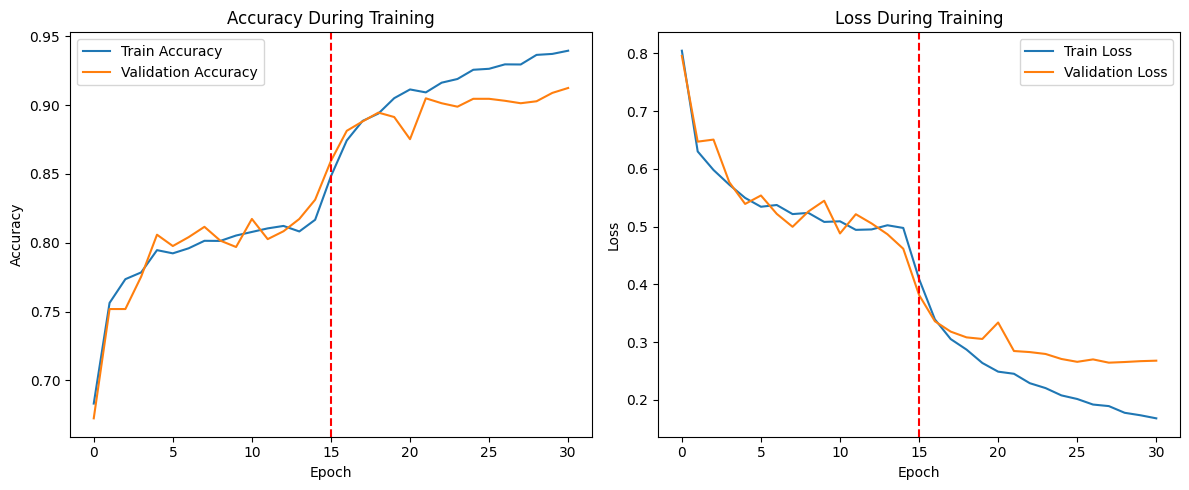

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

train_clean_path = '/kaggle/working/train_clean'
test_clean_path = '/kaggle/working/test_clean'
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

num_classes = 6

def create_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_clean_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        train_clean_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    test_generator = test_datagen.flow_from_directory(
        test_clean_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
frozen_model = Model(inputs=base_model.input, outputs=predictions)

frozen_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

train_gen, val_gen, test_gen = create_generators()

print("\n=== FEATURE EXTRACTION PHASE ===")
feature_extraction_history = frozen_model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

def fine_tune_model(model, base_model):
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    model.compile(
        optimizer=SGD(learning_rate=0.0001, momentum=0.9),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("\n=== FINE-TUNING PHASE ===")
tunable_model = fine_tune_model(frozen_model, base_model)
fine_tune_history = tunable_model.fit(
    train_gen,
    epochs=30,
    initial_epoch=feature_extraction_history.epoch[-1],
    validation_data=val_gen,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
    ],
    verbose=1
)

def combine_histories(hist1, hist2):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

full_history = combine_histories(feature_extraction_history, fine_tune_history)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(full_history['accuracy'], label='Train Accuracy')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
plt.axvline(len(feature_extraction_history.epoch), color='r', linestyle='--')
plt.title('Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(full_history['loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.axvline(len(feature_extraction_history.epoch), color='r', linestyle='--')
plt.title('Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("\nModel Input Shape:", frozen_model.input_shape)
print("Generator Output Shape:", next(train_gen)[0].shape[1:])


Model Input Shape: (None, 150, 150, 3)
Generator Output Shape: (150, 150, 3)


In [ ]:
print("\nModel Output Configuration:")
print("Number of classes:", frozen_model.output_shape[1])
print("Class indices:", train_gen.class_indices)

sample_batch = next(train_gen)
predictions = frozen_model.predict(sample_batch[0])
print("\nSample predictions shape:", predictions.shape)
print("Predicted class for first sample:", np.argmax(predictions[0]))
print("Actual class:", np.argmax(sample_batch[1][0]))


Model Output Configuration:
Number of classes: 6
Class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step

Sample predictions shape: (32, 6)
Predicted class for first sample: 4
Actual class: 4


3.2.3 Model Evaluation and Prediction

In [ ]:

def comprehensive_evaluation(model, model_name, test_generator):
    test_loss, test_acc = model.evaluate(test_generator)
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    report = classification_report(y_true, y_pred_classes,
                                 target_names=class_names, output_dict=True)

    cm = confusion_matrix(y_true, y_pred_classes)

    return {
        'model': model_name,
        'accuracy': test_acc,
        'loss': test_loss,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
        'confusion_matrix': cm
    }

print("\n=== COMPREHENSIVE EVALUATION ===")
results = {
    'baseline': comprehensive_evaluation(baseline_model, "Baseline", test_gen),
    'deeper': comprehensive_evaluation(deeper_model, "Deeper", test_gen),
    'transfer': comprehensive_evaluation(tunable_model, "Transfer", test_gen)
}

results_df = pd.DataFrame.from_dict(results, orient='index')
print("\nModel Comparison:")
display(results_df[['accuracy', 'loss', 'precision', 'recall', 'f1']].style
       .background_gradient(cmap='Blues', subset=['accuracy', 'f1'])
       .background_gradient(cmap='Reds_r', subset=['loss']))


=== COMPREHENSIVE EVALUATION ===
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8690 - loss: 0.3903
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9069 - loss: 0.9536
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.9021 - loss: 0.2817
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step

Model Comparison:


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


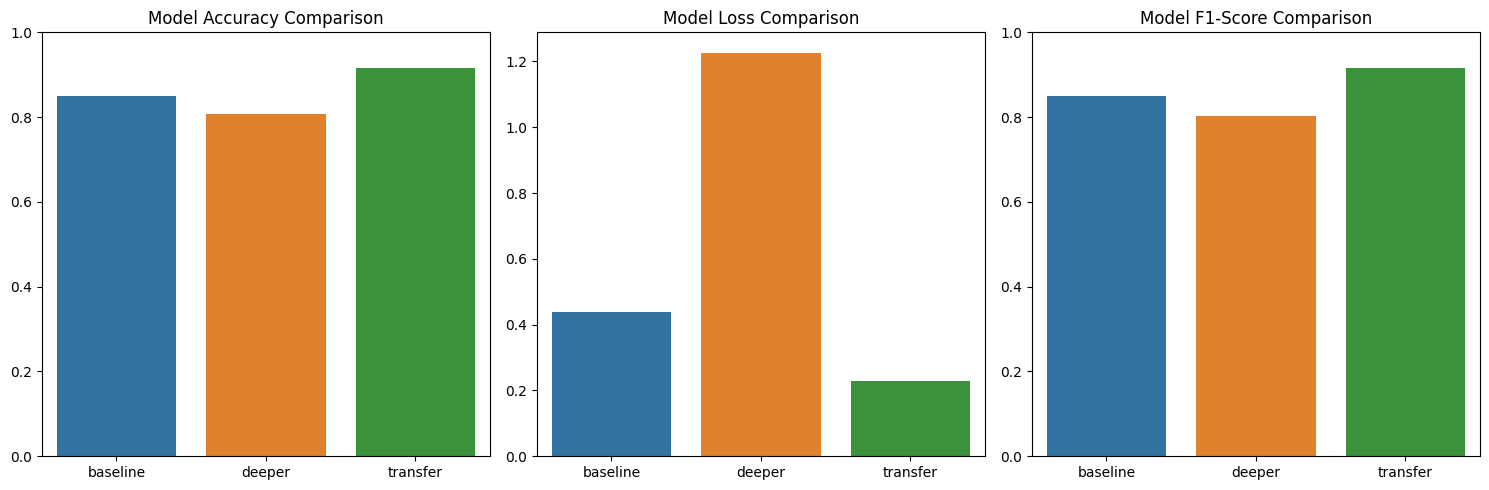

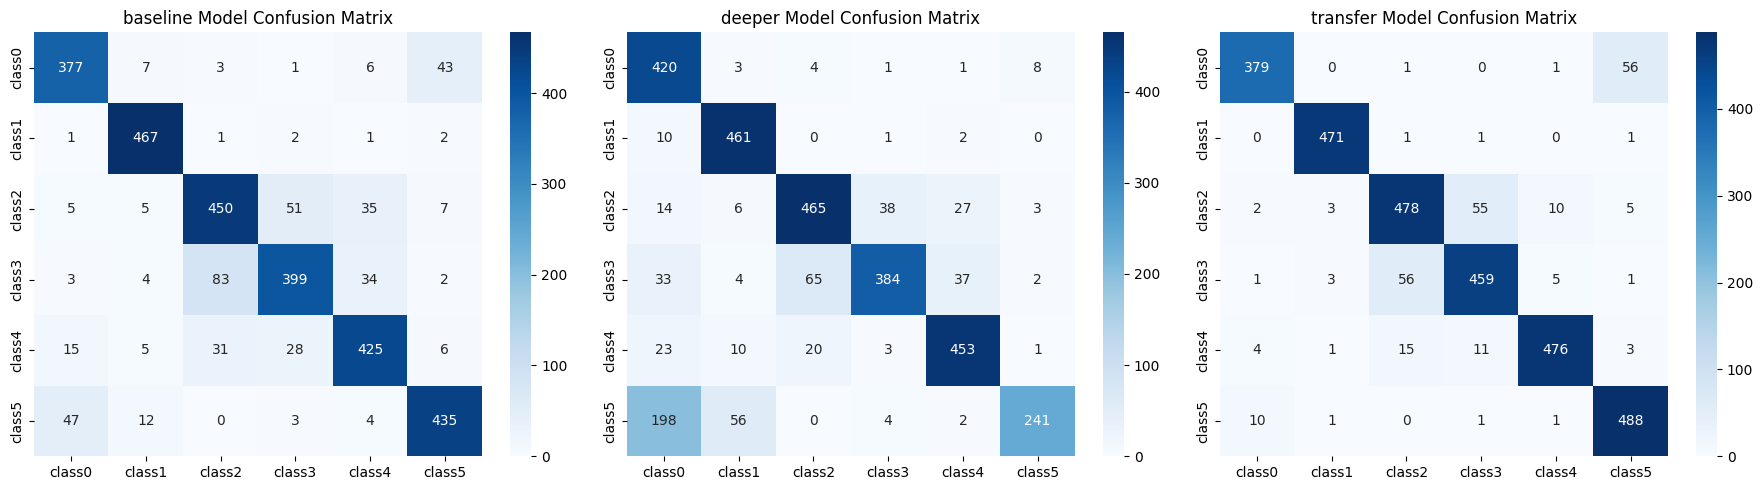

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=list(results.keys()), y=[r['accuracy'] for r in results.values()])
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
sns.barplot(x=list(results.keys()), y=[r['loss'] for r in results.values()])
plt.title('Model Loss Comparison')

plt.subplot(1, 3, 3)
sns.barplot(x=list(results.keys()), y=[r['f1'] for r in results.values()])
plt.title('Model F1-Score Comparison')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 5))
for i, (name, res) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} Model Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
class_results = {}
for cls in class_names:
    class_results[cls] = {
        'baseline': results['baseline']['precision'],
        'deeper': results['deeper']['precision'],
        'transfer': results['transfer']['precision']}

class_df = pd.DataFrame(class_results)
print("\nClass-wise Precision Comparison:")
display(class_df.style.background_gradient(cmap='Blues'))


Class-wise Precision Comparison:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


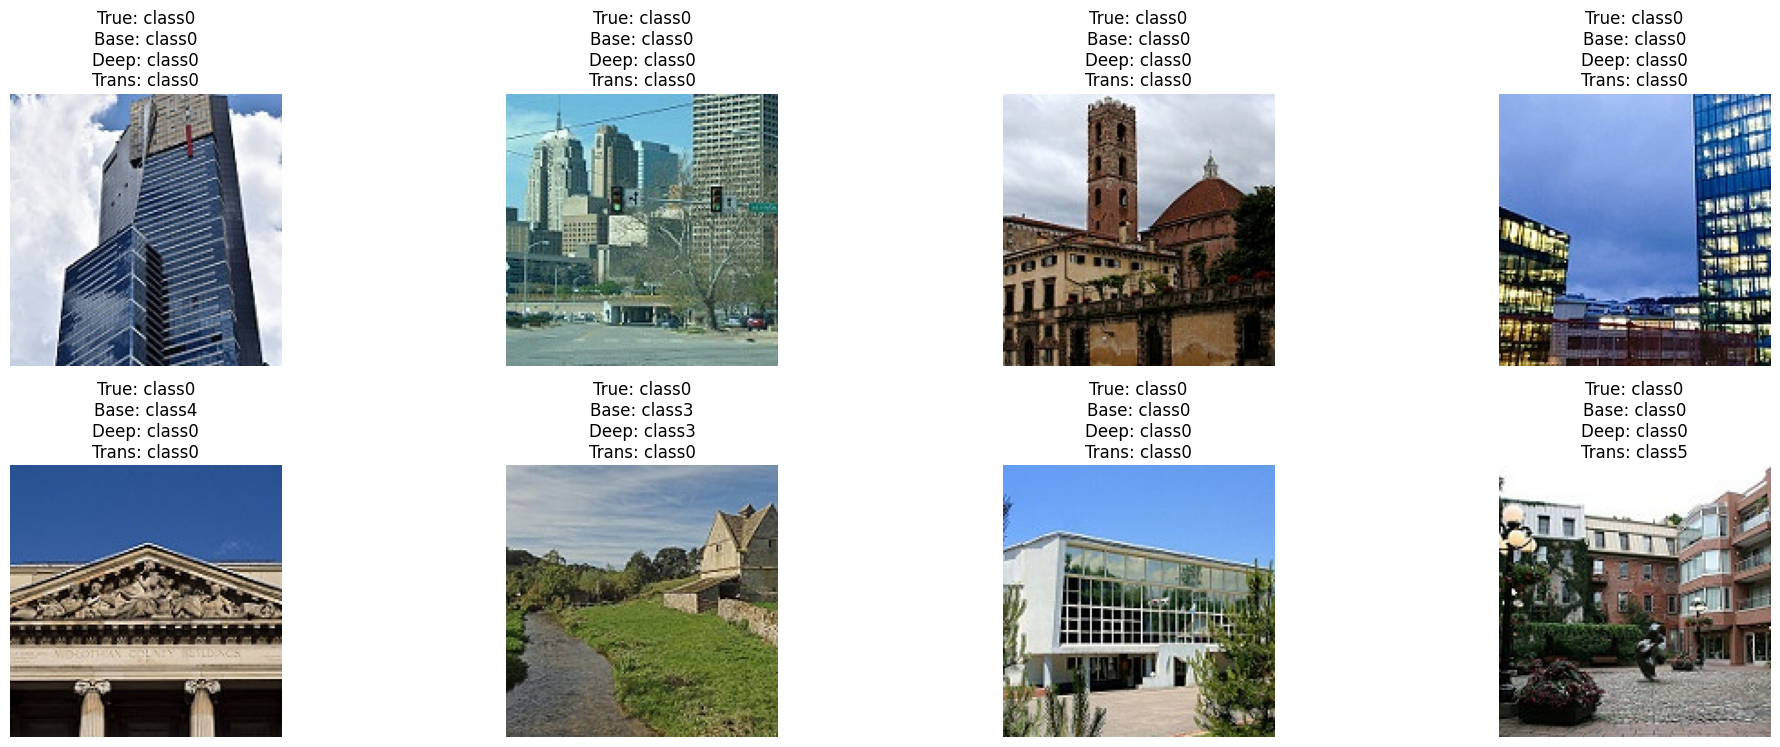

In [ ]:
x_samples, y_samples = next(test_gen)
y_true_samples = np.argmax(y_samples, axis=1)

baseline_pred = baseline_model.predict(x_samples)
deeper_pred = deeper_model.predict(x_samples)
transfer_pred = tunable_model.predict(x_samples)

plt.figure(figsize=(20, 15))
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_samples[i])
    true_class = class_names[y_true_samples[i]]

    b_pred = class_names[np.argmax(baseline_pred[i])]
    d_pred = class_names[np.argmax(deeper_pred[i])]
    t_pred = class_names[np.argmax(transfer_pred[i])]

    plt.title(f"True: {true_class}\n"
              f"Base: {b_pred}\n"
              f"Deep: {d_pred}\n"
              f"Trans: {t_pred}")
    plt.axis('off')
plt.tight_layout()
plt.show()